In [81]:
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

In [82]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
dataset["remarks"] = "No DLC available"
datasets["ROAD"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
# dataset["remarks"] = "-"
# datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,t,ID,dt,dt_ID,ones,ones_ID,run_diff,run_diff_ID,dataset,type,Label
0,1.030000e+09,852,4.073523e-04,0.009999,9,5,0.777778,0.666667,ROAD,none,0
1,1.030000e+09,1505,1.019955e-03,0.009999,21,6,0.916667,0.750000,ROAD,none,0
2,1.030000e+09,651,1.072884e-06,0.019998,0,5,0.000000,0.800000,ROAD,none,0
3,1.030000e+09,167,2.026558e-06,0.009999,19,5,0.857143,0.750000,ROAD,none,0
4,1.030000e+09,208,9.536743e-07,0.009998,18,3,0.818182,0.500000,ROAD,none,0
...,...,...,...,...,...,...,...,...,...,...,...
3266459,1.280000e+09,813,1.192093e-06,0.050870,7,6,0.777778,0.800000,ROAD,none,0
3266460,1.280000e+09,737,9.977818e-04,0.019898,1,5,0.333333,0.750000,ROAD,none,0
3266461,1.280000e+09,852,2.145767e-06,0.010723,22,5,0.666667,0.666667,ROAD,none,0
3266462,1.280000e+09,961,9.536743e-07,0.025351,33,5,0.888889,0.666667,ROAD,none,0


In [83]:
df = df.loc[df["type"] != "masq"]

In [84]:
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "ID", "DLC", "t"], inplace=True, errors="ignore")

display(df)

,dt,dt_ID,ones,ones_ID,run_diff,run_diff_ID,dataset,type,Label
0,4.073523e-04,0.009999,9,5,0.777778,0.666667,ROAD,none,0
1,1.019955e-03,0.009999,21,6,0.916667,0.750000,ROAD,none,0
2,1.072884e-06,0.019998,0,5,0.000000,0.800000,ROAD,none,0
3,2.026558e-06,0.009999,19,5,0.857143,0.750000,ROAD,none,0
4,9.536743e-07,0.009998,18,3,0.818182,0.500000,ROAD,none,0
...,...,...,...,...,...,...,...,...,...
3266459,1.192093e-06,0.050870,7,6,0.777778,0.800000,ROAD,none,0
3266460,9.977818e-04,0.019898,1,5,0.333333,0.750000,ROAD,none,0
3266461,2.145767e-06,0.010723,22,5,0.666667,0.666667,ROAD,none,0
3266462,9.536743e-07,0.025351,33,5,0.888889,0.666667,ROAD,none,0


In [85]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "Label")] = StandardScaler(copy=True).fit_transform(
#     df.loc[:, (df.columns != "type") & (df.columns != "dataset") & (df.columns != "Label")]
# )

# display(df)

In [86]:
X_train = df.drop(columns="type")
y_train = df["type"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

In [87]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		22262		961175
Attack		22262		9541


In [88]:
# X_test = X_test.loc[(X_test["type"] == "fuzz") | (X_test["type"] == "none")]
# y_test = y_test.loc[X_test.index]

In [89]:
X_train.drop(columns=["type", "dataset"], inplace=True)
X_test.drop(columns=["type", "dataset"], inplace=True)

In [90]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2").fit(X_train, y_train)

Training F1: 0.9999 (+/- 0.0001)
Testing F1:  0.9998(+/- 0.0000)
Kappa score:  0.9873(+/- 0.0000)


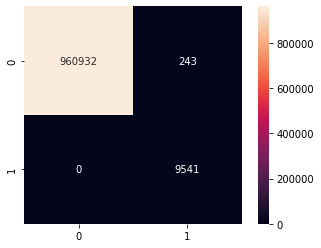

In [91]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

cm = confusion_matrix(y_test, pred)
annots = pd.DataFrame(confusion_matrix(y_test, pred)).applymap(str)
sns.heatmap(cm, annot=annots, fmt="s", square=True)
plt.show()

# Total attack: 465758,     Total normal: 54994
# All below are random_seed=0
# Not under-sampled:        FN=387, FP=286
# Under-sampled:            FN=119, FP=1149
# Under-sampled (type):     FN=176, FP=1363

# Scaled and Under-sampled: FN=116, FP=1214

# RF: 20 trees, log2

# Survival

# Data: Scaled and Under-sampled
# FN=106, FP=885 (run_diff)
# FN=109, FP=775 (run_diff, run_diff_ID)
# FN=130, FP=896 (run_diff, run_diff_ID both subtract zero_runs from one_runs)
# Fn=103, FP=487 (run_diff, run_diff_ID both have one_runs/(zero_runs+1), +1 to avoid division by 0)
# Data: Scaled (Standard) and Under-sampled
# Fn=100, FP=477 (run_diff, run_diff_ID both have one_runs/(zero_runs+1), +1 to avoid division by 0)
# Data: Under-sampled (not Scaled)
# Fn=100, FP=475 (run_diff, run_diff_ID both have one_runs/(zero_runs+1), +1 to avoid division by 0)

# Data: Under-sampled (not Scaled), run_diff and run_diff_ID (one_runs/(zero_runs+1))
# Fabrication:  FNR=0.001697433     FPR=0.001019843
# Flooding:     FNR=0               FPR=0.001019843
# Fuzzing:      FNR=0.004392616     FPR=0.001019843

# ORNL/ROAD (without Masquerade)

# Data: Under-sampled, Scaled (Standard), run_diff and run_diff_ID (one_runs/(zero_runs+1))
# All attacks:  FNR=0               FPR=0.000258018
# Data: Under-sampled (not Scaled), run_diff and run_diff_ID (one_runs/(zero_runs+1))
# All attacks:  FNR=0               FPR=0.000252816